# Notebook para la registración de la distribución de dosis 2D medida (film) con la distribución de dosis de referencia (planificada)

In [4]:
import dicom
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, fixed

ImportError: No module named SimpleITK

In [3]:
def resample(image, reference_image, transform):
    
    interpolator = sitk.sitkLinear # cambiar por primeros vecinos
    default_value = 0.0
    return sitk.Resample(image, reference_image, transform, interpolator, default_value)

def affine_scale_and_translate(image, reference_image, scale, x_translation, y_translation):
    
    transform = sitk.AffineTransform(2)
    matrix = np.array(transform.GetMatrix()).reshape((2,2))
    matrix[0,0] = scale # modificar la matriz de forma tal que el escalamiento se haga desde el centro en lugar del vertice
    matrix[1,1] = scale
    transform.SetMatrix(matrix.ravel())
    transform.SetTranslation((x_translation, y_translation))
    
    return resample(image, reference_image, transform)
      
    
# esta funcion recibe imagenes y grafica. Sería conveniente que devuelva una imagen y que el graficado se haga afuera
# pero me parece que no es posible dado que está dentro de un interact 
def display_images_with_alpha(x_translation, y_translation, scale, alpha, color_limits, fixed_img, moving_img, reference_image):
    
    moving_img = affine_scale_and_translate(moving_img, reference_image, scale, x_translation, y_translation)
    
    img = (1.0 - alpha)*fixed_img + alpha*moving_img
    
    plt.figure(figsize = (10,10))
    plt.imshow(sitk.GetArrayFromImage(img),cmap=plt.cm.Greys_r);
    #plt.axis('off')
    plt.clim(color_limits[0], color_limits[1])
    plt.show()
    
    return moving_img
    

## Carga de las imágenes

In [4]:
# Load dicom 2D distribution (reference image)
plan = pydicom.read_file('C:\Users\Roy\Desktop\Exp4\Archivos\Tailandia\Siriraj\Dose plane_IMRT at 1.5cm_1F\CIRS Phantom IMRT.dcm')
planed_array = plan.pixel_array*plan.DoseGridScaling
planed_array = planed_array.astype(np.float32)

planed_size = planed_array.shape
print planed_size

(256L, 256L)


In [5]:
# Load film dosimetry image
film_image_color = sitk.ReadImage('C:\Users\Roy\Desktop\Exp4\Archivos\Tailandia\Siriraj\siriraj_phantom2.tif',-1)
film_array = sitk.GetArrayFromImage(film_image_color) # este slicing para sacar el canal rojo, puede hacerse directamente en sitk
film_array = film_array[:,:,0].astype(np.float32) 

film_array = 2.0*film_array/film_array.max() # esto es un escaleo arbitrario, debe ser remplazado por la calibracion

film_size = film_array.shape
print film_size

film_array.shape

(511L, 598L)


(511L, 598L)

## Grafico las dos imágenes cargadas
Grafico las dos imagenes en escala de grises y con su tamaño original

[0.0, 2.0]
[0.0, 0.5402047]


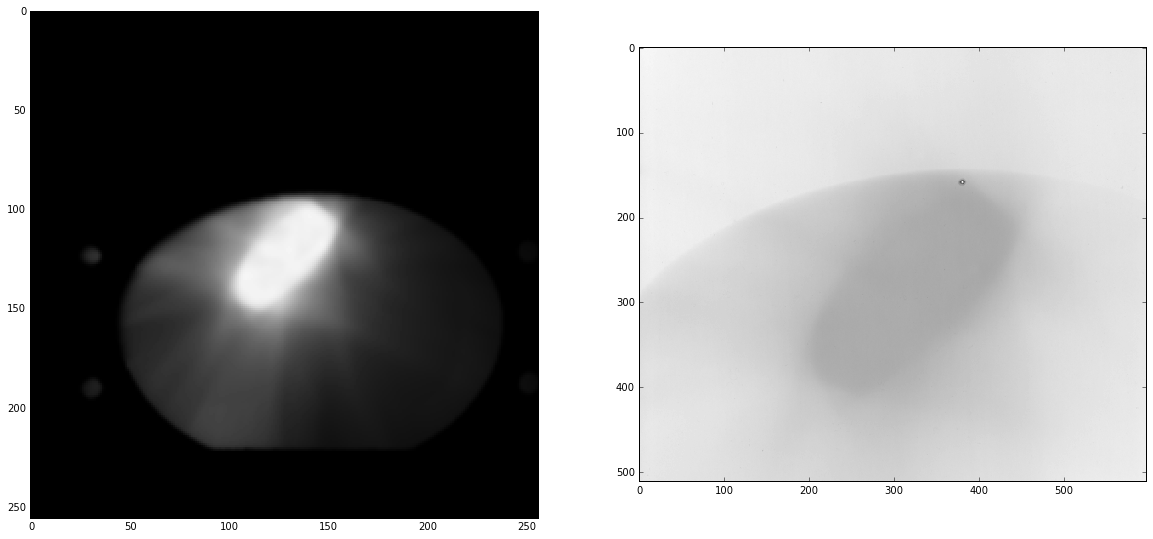

In [7]:
color_limits = [np.amin([planed_array.min(), film_array.min()]), np.amax([planed_array.max(), film_array.max()])]

print color_limits
print [planed_array.min(), film_array.min()]

plt.figure(figsize = (20,20))

plt.subplot(121)
plt.imshow(planed_array , cmap = 'gray', interpolation = 'nearest')
#plt.axis('off') # to hide tick values on X and Y axis
plt.clim(color_limits[0],color_limits[1])

plt.subplot(122)
plt.imshow(film_array , cmap = 'gray', interpolation = 'nearest')
#plt.axis('off')
plt.clim(color_limits[0],color_limits[1])

plt.show()

## Aproximación inicial
Grafico las dos imágenes juntas sobre un array cuyas dimensiones alcance para ambas

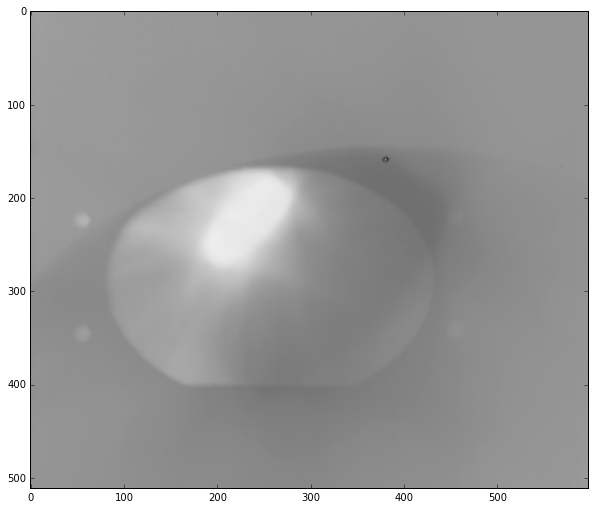

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x000000000C351E10> >

In [9]:
film_image = sitk.GetImageFromArray(film_array)
planed_image = sitk.GetImageFromArray(planed_array)

row_max = np.amax([planed_size[0],film_size[0]]) 
column_max = np.amax([planed_size[1],film_size[1]]) 

canvas_array = np.zeros([row_max,column_max]) # la creacion de esta imagen puede hacerse directamente en sitk
canvas_image = sitk.GetImageFromArray(canvas_array)

affine = sitk.AffineTransform(2)

planed_rsmpld = sitk.Resample(planed_image, canvas_image, affine, sitk.sitkLinear, 0.0, planed_image.GetPixelIDValue())
film_rsmpld = sitk.Resample(film_image, canvas_image, affine, sitk.sitkLinear, 0.0, planed_image.GetPixelIDValue())


planed_rsmpld =  interact(display_images_with_alpha,  x_translation=(-100.0, 100.0), y_translation=(-100.0, 100.0), 
         scale=(0.1, 1.0, 0.01), alpha=(0.0,1.0,0.05), color_limits = fixed(color_limits), fixed_img = fixed(film_rsmpld), 
         moving_img=fixed(planed_rsmpld),reference_image=fixed(canvas_image));

In [28]:
print film_rsmpld
print planed_rsmpld

Image (000000000BDB2ED0)
  RTTI typeinfo:   class itk::Image<float,2>
  Reference Count: 1
  Modified Time: 64885
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 64877
  UpdateMTime: 64884
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 2
    Index: [0, 0]
    Size: [598, 511]
  BufferedRegion: 
    Dimension: 2
    Index: [0, 0]
    Size: [598, 511]
  RequestedRegion: 
    Dimension: 2
    Index: [0, 0]
    Size: [598, 511]
  Spacing: [1, 1]
  Origin: [0, 0]
  Direction: 
1 0
0 1

  IndexToPointMatrix: 
1 0
0 1

  PointToIndexMatrix: 
1 0
0 1

  Inverse Direction: 
1 0
0 1

  PixelContainer: 
    ImportImageContainer (000000000623C1B0)
      RTTI typeinfo:   class itk::ImportImageContainer<unsigned __int64,float>
      Reference Count: 1
      Modified Time: 64882
      Debug: Off
      Object Name: 
      Observers: 
        non

## Registración


TypeError: in method 'GetByteArrayFromImage', argument needs to be of type 'sitk::Image *'

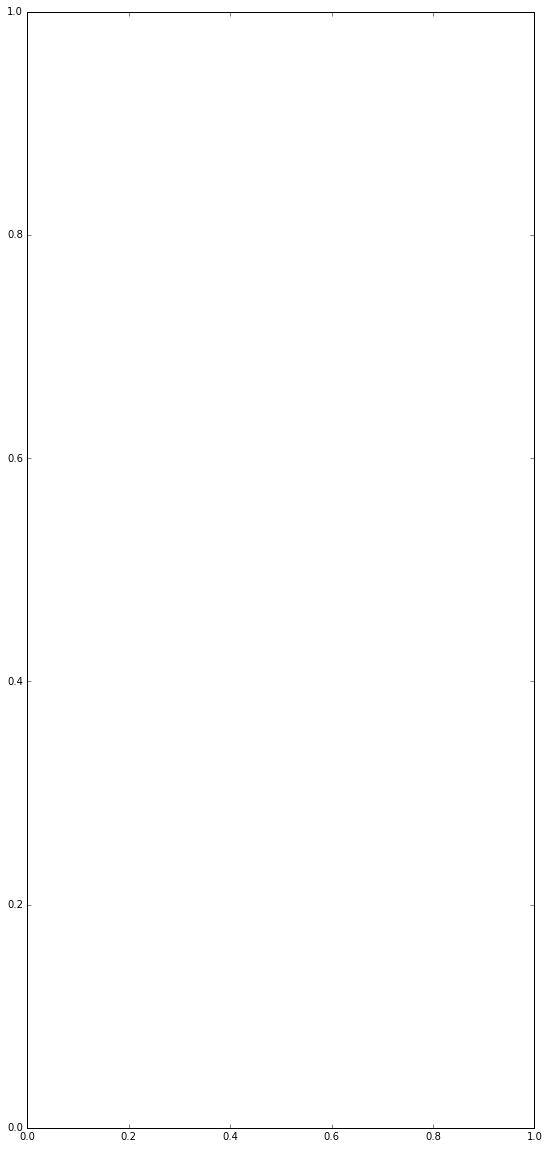

In [26]:
plt.figure(figsize = (20,20))

plt.subplot(121)
plt.imshow(sitk.GetArrayFromImage(planed_rsmpld) , cmap = 'gray', interpolation = 'nearest')
#plt.axis('off') # to hide tick values on X and Y axis
plt.clim(color_limits[0],color_limits[1])

plt.subplot(122)
plt.imshow(sitk.GetArrayFromImage(film_rsmpld) , cmap = 'gray', interpolation = 'nearest')
#plt.axis('off')
plt.clim(color_limits[0],color_limits[1])

plt.show() 